In [47]:
import os
import time
import warnings
import math
import argparse 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler 

warnings.filterwarnings('ignore')

import sys
project_root = os.path.abspath('./') 
if project_root not in sys.path:
    sys.path.append(project_root)

from exp.exp_main import Exp_Main
from models import xPatch 
from data_provider.data_factory import data_provider
from data_provider.data_loader import Dataset_Custom 
from utils.tools import EarlyStopping, adjust_learning_rate, visual
from utils.metrics import metric

In [56]:
class Args:
    def __init__(self):
        self.is_training = 1
        self.train_only = False
        self.model_id = 'AAPL_Pred5_Notebook_Tuned'
        self.model = 'xPatch'

        self.data = 'custom'
        self.scale = True
        self.root_path = './data/' 
        self.data_path = 'aapl_OHLCV.csv'
        self.features = 'MS' # Multiple Features, Single target
        self.target = 'Close' # The target feature
        self.freq = 'd'
        self.checkpoints = './checkpoints/' 
        self.embed = 'timeF' 

####################################################################################################################################################
# Hyperparameter Tuning
        # Forecasting Task
        self.seq_len = 48
        self.label_len = 48
        self.pred_len = 5
        self.enc_in = 9 # Ensure this matches the number of features in the CSV after 'date'

        # Patching
        self.patch_len = 12
        self.stride = 6
        self.padding_patch = 'end'

        # Moving Average
        self.ma_type = 'ema'
        self.alpha = 0.2
        self.beta = 0.2

        # Optimization
        self.num_workers = 8 # Adjust based on your system 
        self.itr = 1 
        self.train_epochs = 3
        self.batch_size = 16
        self.patience = 15
        self.learning_rate = 0.0001
        self.des = 'Notebook_Run_MS'
        self.loss = 'mae' 
        self.lradj = 'type1' # learning rate strategy
        self.revin = 1 
####################################################################################################################################################

        # GPU
        self.use_gpu = True if torch.cuda.is_available() else False
        self.gpu = 0 
        self.use_multi_gpu = False 
        self.devices = '0' 
        self.test_flop = False 

args = Args()

if not os.path.exists(args.checkpoints):
    os.makedirs(args.checkpoints)

In [53]:

exp = Exp_Main(args)

print(f'Args for this run: {vars(args)}')

best_model = exp.train(args.model_id)


Use GPU: cuda:0
Args for this run: {'is_training': 1, 'train_only': False, 'model_id': 'AAPL_Pred5_Notebook_Tuned', 'model': 'xPatch', 'data': 'custom', 'scale': False, 'root_path': './data/', 'data_path': 'aapl_OHLCV.csv', 'features': 'MS', 'target': 'Close', 'freq': 'd', 'checkpoints': './checkpoints/', 'embed': 'timeF', 'seq_len': 48, 'label_len': 48, 'pred_len': 5, 'enc_in': 9, 'patch_len': 12, 'stride': 6, 'padding_patch': 'end', 'ma_type': 'ema', 'alpha': 0.2, 'beta': 0.2, 'num_workers': 8, 'itr': 1, 'train_epochs': 3, 'batch_size': 16, 'patience': 15, 'learning_rate': 0.0001, 'des': 'Notebook_Run_MS', 'loss': 'mae', 'lradj': 'type1', 'revin': 0, 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0', 'test_flop': False}
train 2666
val 386
test 772
	iters: 100, epoch: 1 | loss: 0.4497606
	speed: 0.2098s/iter; left time: 83.7022s
Epoch: 1 cost time: 21.86066770553589
Epoch: 1, Steps: 166 | Train Loss: 0.4139897 Vali Loss: 3.0644363 Test Loss: 49.7919710
Validation loss 

AAPL_Pred5_Notebook_Tuned
test 772
mse:49.41897964477539, mae:6.885569095611572


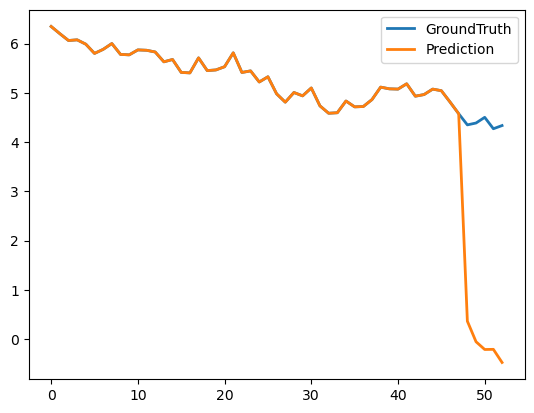

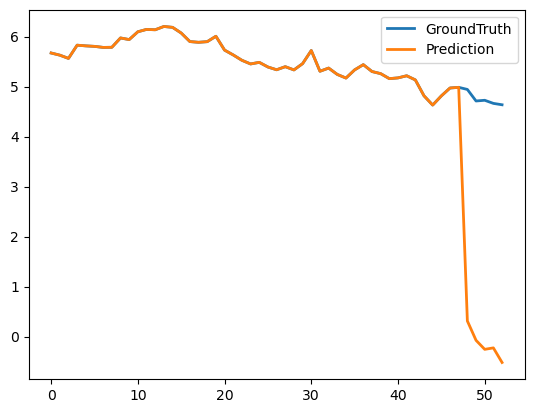

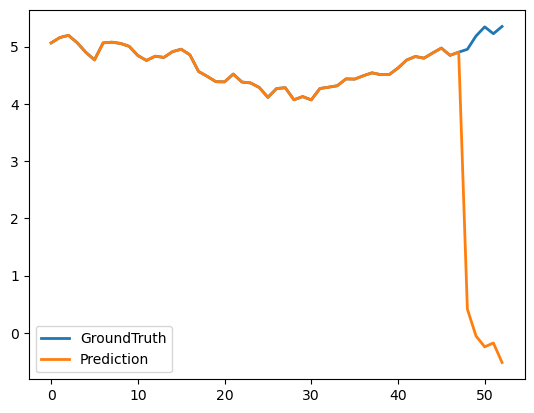

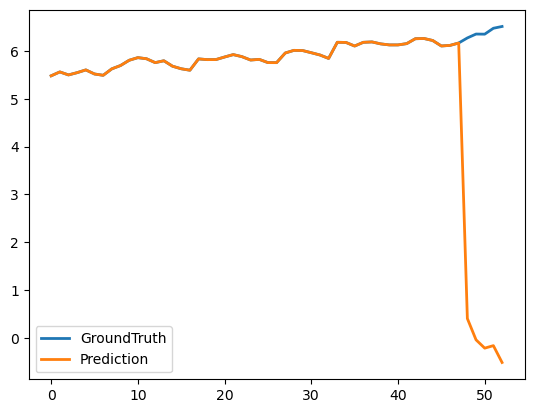

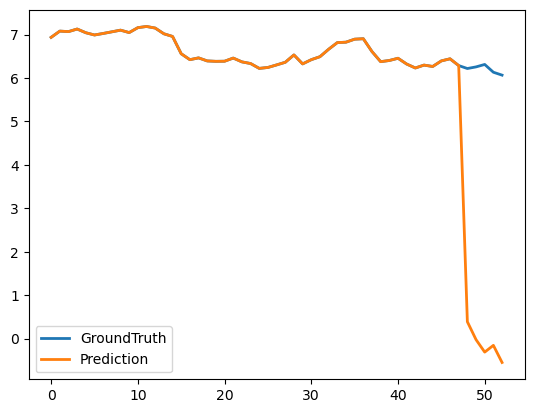

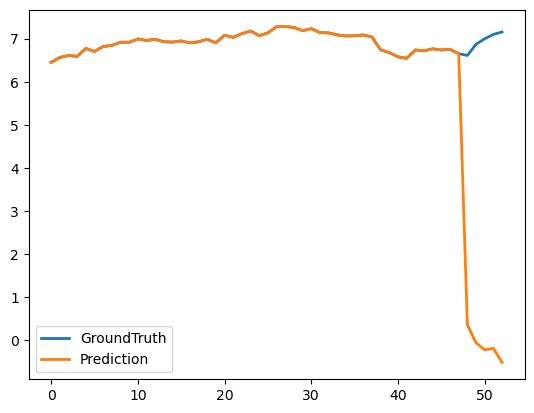

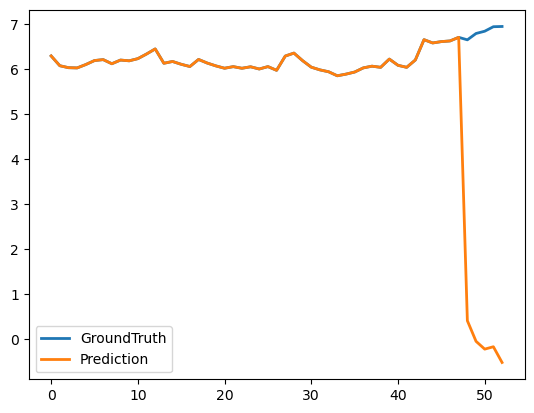

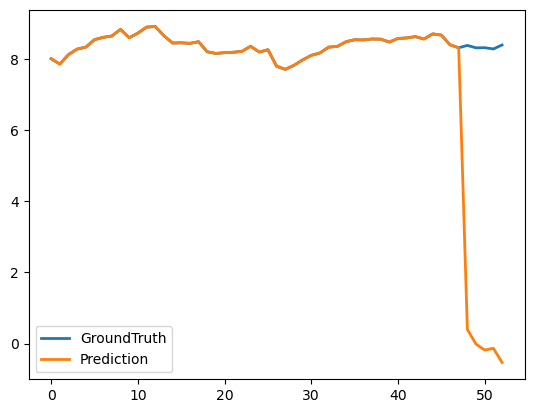

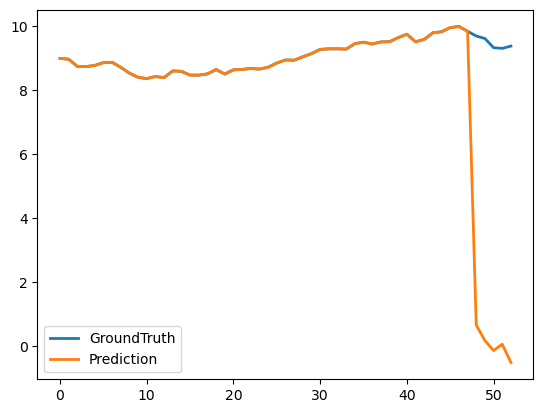

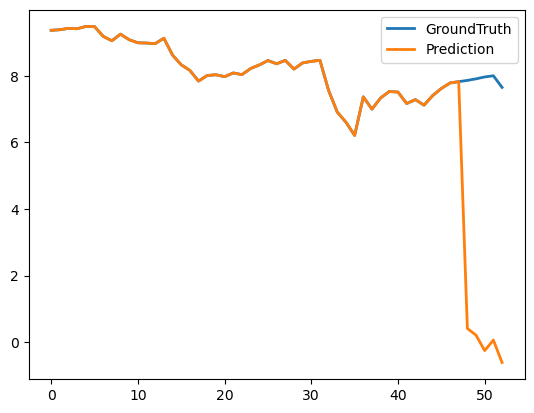

In [54]:
print(args.model_id)
exp.test(args.model_id)


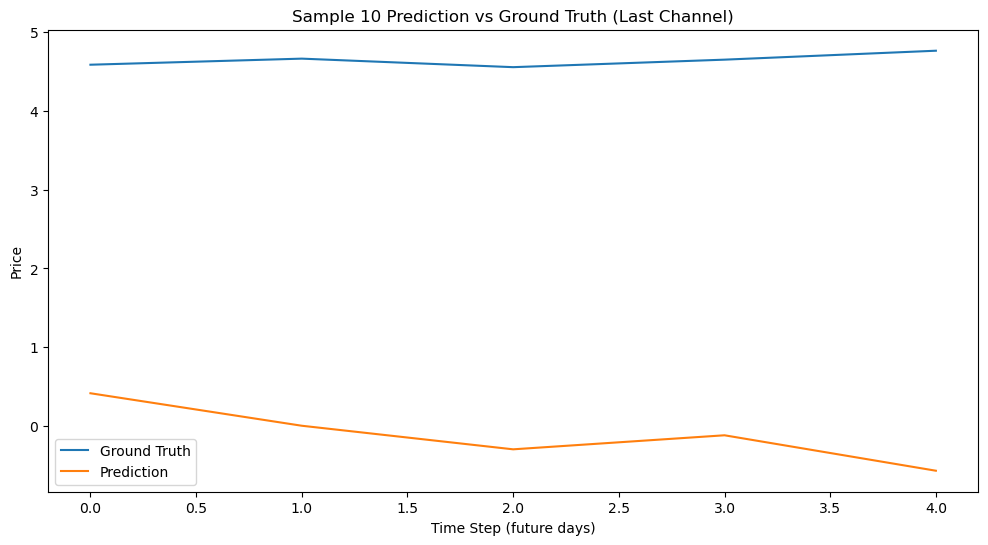

In [55]:
folder_path = os.path.join('./test_results/', args.model_id + '/')
predictions_path = os.path.join(folder_path, 'pred.npy')
trues_path = os.path.join(folder_path, 'true.npy')

if os.path.exists(predictions_path) and os.path.exists(trues_path):
    all_preds = np.load(predictions_path)
    all_trues = np.load(trues_path)

    import matplotlib.pyplot as plt


    sample_idx = 10 # Pick a sample to visualize

    plt.figure(figsize=(12, 6))
    plt.plot(all_trues[sample_idx, :, 0], label='Ground Truth')
    plt.plot(all_preds[sample_idx, :, 0], label='Prediction')
    plt.title(f'Sample {sample_idx} Prediction vs Ground Truth (Last Channel)')
    plt.xlabel('Time Step (future days)')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(False)
    plt.show()

else:
    print("Prediction and true value files not found. Ensure test() ran successfully.")